# Analysis

For each query specified in the assignment, compute the answers. Include a plot of
these results in this notebook. Briefly discuss what you can observe from these results. Beware that for some queries, not all of the sub-dataset types have the information required to answer the query. In that case, please ignore those sub-datasets

In [5]:
# Imports go here
import os
import glob
import pandas as pd
import os 
import shutil
import datetime
import geopandas as gpd
from datetime import date
from datetime import datetime
from pyspark.sql.functions import col, lit
import pyspark.sql.functions as f
from pyspark.sql.functions import hour, mean
from shutil import copyfile
from shapely.geometry import Point
import matplotlib.pyplot as plt

os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=3g  pyspark-shell"
from pyspark.sql import SparkSession
try: 
    spark
    print("Spark application already started. Terminating existing application and starting new one")
    spark.stop()
except: 
    pass
# Create a new spark session (note, the * indicates to use all available CPU cores)
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("H600 L-Group") \
    .getOrCreate()
#When dealing with RDDs, we work the sparkContext object. See https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext
sc=spark.sparkContext
#in local mode, you will be able to access the Spark GUI at http://localhost:4040

Spark application already started. Terminating existing application and starting new one


## Declaration of usefull functions and parameters

In [6]:
## FUNCTION DECLARATION
# Creation of a function to convert lat-lon into location ID
def convertlocID(lon, lat):
    """
    This function define the location ID from the latitude and longitude coordinates.
    It assumes that the files taxis_zones.shp is already loaded and converted unsing the epsg 4326 projection.
    
    Input: the latitude and longitude.      
    Output: the locationID deduce from GPS positions.
    """  
    global locationID # access the outer scope variable by declaring it global
    if lon != None and lat != None and lon < -73.0 and lon > -75.0 and lat > 40.0 and lat < 42.0:
        query_point = Point( lon, lat)
        possible_matches = list(rtree.intersection( query_point.bounds ))
        for i in range(0,len(possible_matches)) :
            if zones.iloc[possible_matches[i]].geometry.contains(query_point) == True :
                locationID = possible_matches[i]
    else:
        locationID = 9999
    
    return locationID

# Check if the value is null or not
def blank_as_null(x):
    """
    This function define blank as null in order to be more easily interpreted.
    
    Input: the column name that need to be check      
    Output: the column corrected
    """  
    return f.when(col(x).isNull(), 0 ).otherwise(col(x))

def create_files_list(path, brand, list_files):
    """
    This function create the files list of specify taxi brand (brand) from the specify folder (path). 
    
    Input: the path where are the files -> /data/cleaned or data/sampled
           the name of the taxi company -> fhv, fhvfh, green, yellow
           the empty file name list in which each file will be append
    Output: number of files in the list and the list of files name.
    """  
    global nb_files
    nb_files = 0
    for file in glob.glob("%s/%s_*.csv" %(path,brand)):
        nb_files = nb_files+1
        # Save in list the files name
        list_files.append(file)
        # Order by date the file list
        list_files.sort()

    return list_files, nb_files

## PARAMETERS DECLARATION
cl_path = "data/cleaned/"

## Taxis companies popularity

How the popularity of a particular service (Yellow Taxi, Green Taxi, FHV, FHVHV) is evolving over time? 

In [156]:

# Get the list of the file for each taxi
green_DF = (spark.read
                .option("sep", ",")
                .option("header", True)
                .option("inferSchema", True)
                .csv(cl_path+"green/*.csv") )

# Get the date of each lines
green_DF = green_DF.orderBy("lpep_pickup_datetime")
year_extract = green_DF.selectExpr("year(lpep_pickup_datetime) AS year", "lpep_pickup_datetime").groupBy("year").sum().orderBy("year").select("year")
list_year = [row[0] for row in year_extract.select('year').collect()]
var = []
month_list = []
print(list_year)
for yr in list_year :
    test = green_DF.where(f.year("lpep_pickup_datetime")==yr)\
                    .selectExpr("month(lpep_pickup_datetime) AS month", "lpep_pickup_datetime")\
                    .groupBy("month").sum().orderBy("month")
    #testing = test.select("month").toPandas()["month"]
    #months =  [row[0] for row in test.select('month').collect()]
    #print(testing)
    var.append([row[0] for row in test.select('sum(month)').collect()]) #test.select("sum(month)").collect())
    month_list.append([row[0] for row in test.select('month').collect()])
    #date_format(df['date_key'],'yyyy-MM')
print(month_list)
    #plt.plot(var[0])    
    #groupBy("month").count()
#green_DF.selectExpr("year(lpep_pickup_datetime) AS year", "lpep_pickup_datetime").groupBy("month").sum().show()
# groupe the date by month
# sum the numbers of travel in a month


[2009, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
[[1], [8, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [1, 2, 3, 4, 5, 6], [1, 2, 4, 5, 6]]


['2009/1/1', '2013/8/1', '2013/9/1', '2013/10/1', '2013/11/1', '2013/12/1', '2014/1/1', '2014/2/1', '2014/3/1', '2014/4/1', '2014/5/1', '2014/6/1', '2014/7/1', '2014/8/1', '2014/9/1', '2014/10/1', '2014/11/1', '2014/12/1', '2015/1/1', '2015/2/1', '2015/3/1', '2015/4/1', '2015/5/1', '2015/6/1', '2015/7/1', '2015/8/1', '2015/9/1', '2015/10/1', '2015/11/1', '2015/12/1', '2016/1/1', '2016/2/1', '2016/3/1', '2016/4/1', '2016/5/1', '2016/6/1', '2016/7/1', '2016/8/1', '2016/9/1', '2016/10/1', '2016/11/1', '2016/12/1', '2017/1/1', '2017/2/1', '2017/3/1', '2017/4/1', '2017/5/1', '2017/6/1', '2017/7/1', '2017/8/1', '2017/9/1', '2017/10/1', '2017/11/1', '2017/12/1', '2018/1/1', '2018/2/1', '2018/3/1', '2018/4/1', '2018/5/1', '2018/6/1', '2018/7/1', '2018/8/1', '2018/9/1', '2018/10/1', '2018/11/1', '2018/12/1', '2019/1/1', '2019/2/1', '2019/3/1', '2019/4/1', '2019/5/1', '2019/6/1', '2020/1/1', '2020/2/1', '2020/4/1', '2020/5/1', '2020/6/1']
[1, 120, 882, 3380, 8316, 14268, 1586, 3974, 7704, 10384,

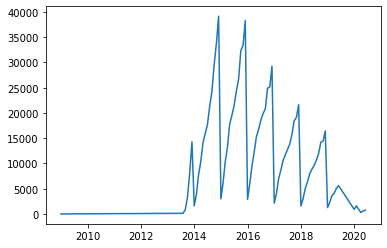

In [162]:
time = [] 
summing = []
for y in range(0,len(month_list)) :
    for m in range(len(month_list[y])) :
        timing = str(list_year[y])+"/"+str(month_list[y][m])+"/1"
        time.append(timing) 
        summing.append(var[y][m])

print(time)
dating = pd.to_datetime(time, infer_datetime_format=True)

print(summing)
plt.plot(dating,summing)
